In [1]:
import cv2
print(cv2.__version__)

import numpy as np
print(np.__version__)

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei"]  # 选择系统中存在的中文字体
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示为方块的问题

from skimage.metrics import structural_similarity as ssim

4.12.0
2.3.5


In [5]:
# 显示图像
def show_images(images, titles, rows=1, cols=1):
    """
    批量显示图像
    :param images: 图像列表
    :param titles: 标题列表
    :param rows: 行数
    :param cols: 列数
    """
    plt.figure(figsize=(15, 10))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


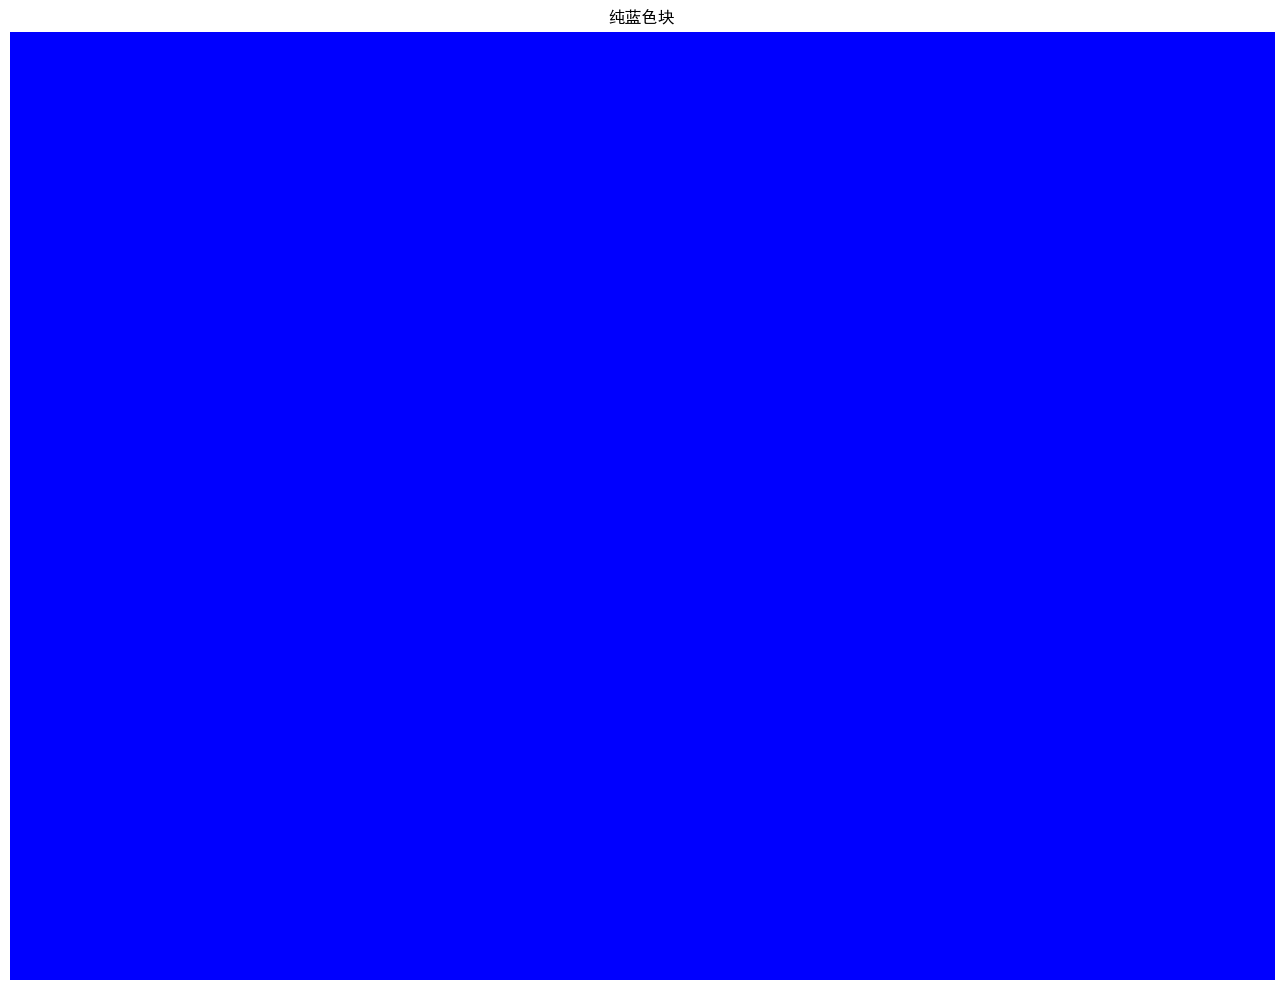

In [10]:
width, height = 320, 240
red_img_rgb = np.full((height, width, 3), (0, 0, 255), dtype=np.uint8)  # BGR顺序：(0,0,255)为红色
show_images([red_img_rgb], ["纯蓝色块"])

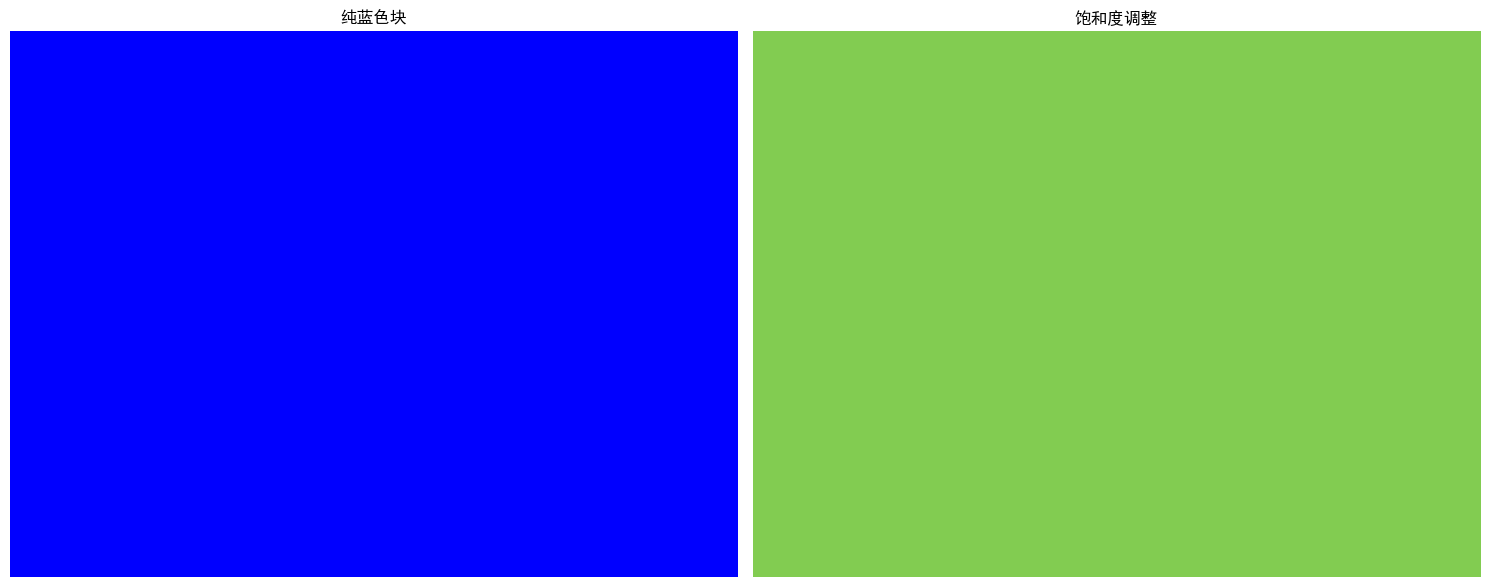

In [61]:
red_img_hsv = cv2.cvtColor(red_img_rgb, cv2.COLOR_RGB2HSV)
h_channel = red_img_hsv[:, :, 0]
s_channel = red_img_hsv[:, :, 1]
v_channel = red_img_hsv[:, :, 2]

h_ratio = 0.4  # 色度保留比例
red_img_hsv[:, :, 0] = h_channel * h_ratio
red_img_hsv[:, :, 0] = np.clip(red_img_hsv[:, :, 0], 0, 255).astype(np.uint8)

s_ratio = 0.6 # 饱和度保留比例（0~1，0为完全灰度，1为原饱和度）
red_img_hsv[:, :, 1] = s_channel * s_ratio
red_img_hsv[:, :, 1] = np.clip(red_img_hsv[:, :, 1], 0, 255).astype(np.uint8)

v_ratio = 0.8 # 亮度保留比例
red_img_hsv[:, :, 2] = v_channel * v_ratio
red_img_hsv[:, :, 2] = np.clip(red_img_hsv[:, :, 2], 0, 255).astype(np.uint8)

gray_red_img_rgb = cv2.cvtColor(red_img_hsv, cv2.COLOR_HSV2RGB)

show_images([red_img_rgb, gray_red_img_rgb], ["纯蓝色块", "饱和度调整"], rows=1, cols=2)

In [62]:
def calculate_hsv_diff(img1, img2):
    """
    计算HSV通道的像素差值
    :param img1: 图像1 (RGB格式)
    :param img2: 图像2 (RGB格式)
    :return: H/S/V通道差值图像、各通道平均差值
    """
    # 转换RGB到HSV
    hsv1 = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
    hsv2 = cv2.cvtColor(img2, cv2.COLOR_RGB2HSV)
    
    # 计算各通道差值
    h_diff = np.abs(hsv1[..., 0] - hsv2[..., 0])
    s_diff = np.abs(hsv1[..., 1] - hsv2[..., 1])
    v_diff = np.abs(hsv1[..., 2] - hsv2[..., 2])
    
    # 平均差值
    h_mean = np.mean(h_diff)
    s_mean = np.mean(s_diff)
    v_mean = np.mean(v_diff)

    # 处理除以零的情况
    def normalize_diff(diff):
        diff_max = diff.max()
        if diff_max == 0:
            return np.zeros_like(diff, dtype=np.uint8)  # 差异为0时返回全0
        return (diff / diff_max * 255).astype(np.uint8)

    # 归一化显示
    h_diff_norm = normalize_diff(h_diff)
    s_diff_norm = normalize_diff(s_diff)
    v_diff_norm = normalize_diff(v_diff)
    
    return (h_diff_norm, s_diff_norm, v_diff_norm), (h_mean, s_mean, v_mean)

def calculate_mse(img1, img2):
    """计算均方误差(MSE)"""
    mse = np.mean((img1 - img2) ** 2)
    return mse

def calculate_ssim(img1, img2):
    """计算结构相似性(SSIM)"""
    # 转换为灰度图（SSIM通常用于单通道）
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    # 计算SSIM
    ssim_score, _ = ssim(gray1, gray2, full=True)
    return ssim_score

def calculate_rgb_diff(img1, img2):
    """
    计算RGB通道的像素差值，并生成差异图像
    :param img1: 图像1 (RGB格式)
    :param img2: 图像2 (RGB格式)
    :return: 差值图像（归一化到0-255）、平均差值
    """
    # 转换为浮点型避免溢出
    img1_float = img1.astype(np.float32)
    img2_float = img2.astype(np.float32)
    
    # 计算每个像素的差值
    diff = np.abs(img1_float - img2_float)
    
    # 平均差值（衡量整体差异）
    mean_diff = np.mean(diff)
    
    # 归一化到0-255（方便显示）
    diff_normalized = (diff / diff.max() * 255).astype(np.uint8)
    
    return diff_normalized, mean_diff

RGB平均差值：169.33


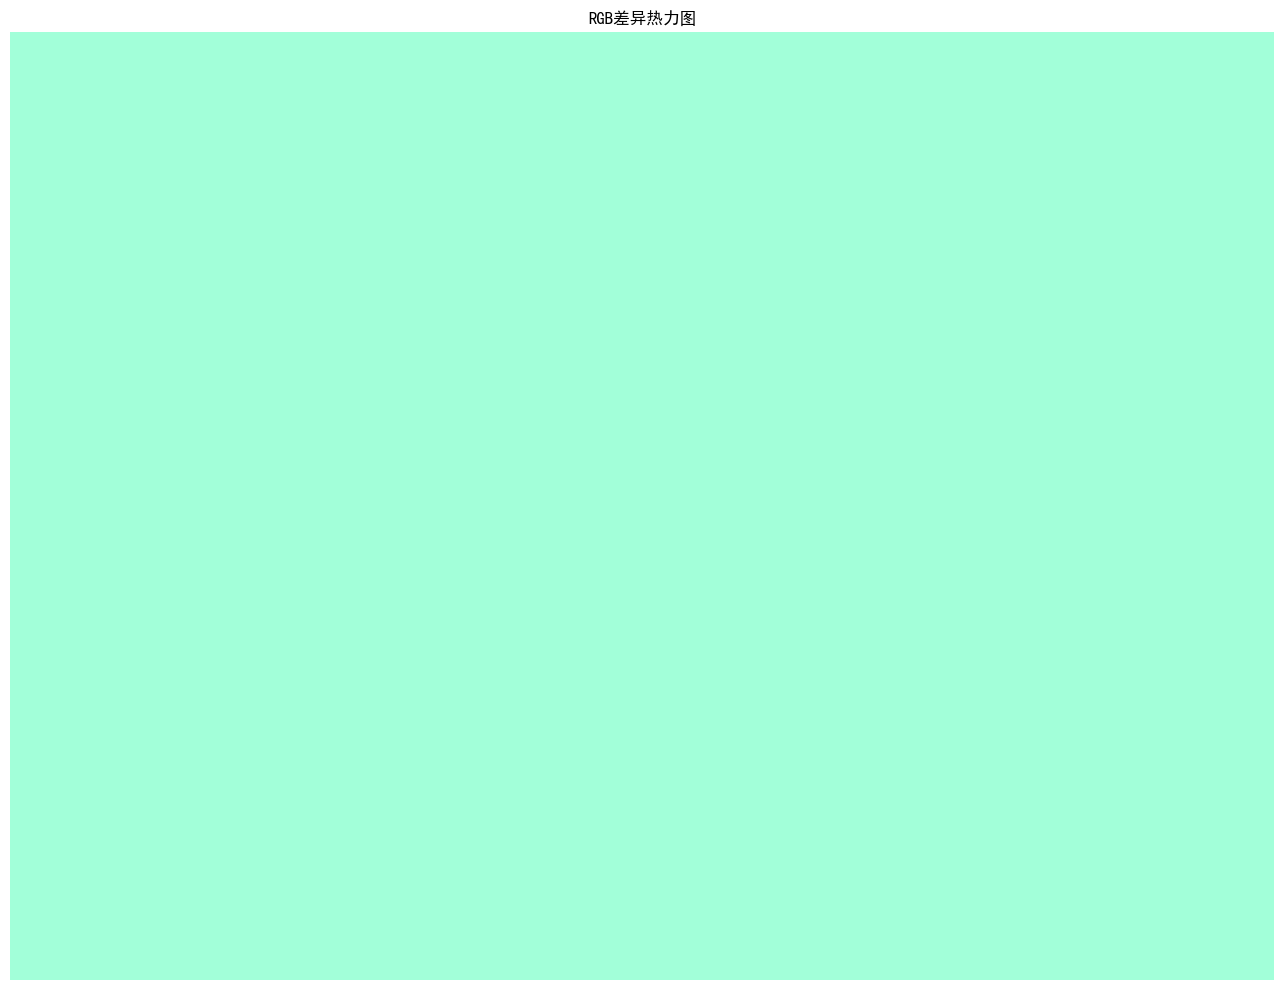

In [63]:
# 4. 计算RGB差异
rgb_diff, rgb_mean = calculate_rgb_diff(red_img_rgb, gray_red_img_rgb)
print(f"RGB平均差值：{rgb_mean:.2f}")
show_images([rgb_diff], ["RGB差异热力图"], rows=1, cols=1)

H通道平均差值：72.00
S通道平均差值：101.00
V通道平均差值：51.00


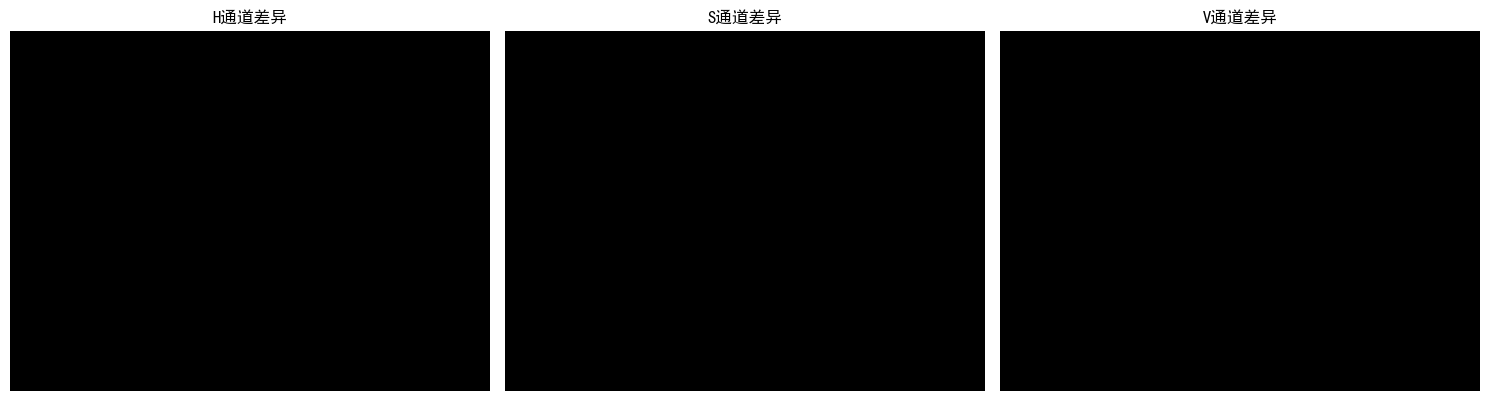

均方误差(MSE)：72.00
结构相似性(SSIM)：0.3354


In [64]:
# 5. 计算HSV差异
hsv_diff, hsv_means = calculate_hsv_diff(red_img_rgb, gray_red_img_rgb)
h_mean, s_mean, v_mean = hsv_means
print(f"H通道平均差值：{h_mean:.2f}")
print(f"S通道平均差值：{s_mean:.2f}")
print(f"V通道平均差值：{v_mean:.2f}")
show_images(hsv_diff, ["H通道差异", "S通道差异", "V通道差异"], rows=1, cols=3)

# 6. 计算定量指标
mse = calculate_mse(red_img_rgb, gray_red_img_rgb)
ssim_score = calculate_ssim(red_img_rgb, gray_red_img_rgb)
print(f"均方误差(MSE)：{mse:.2f}")
print(f"结构相似性(SSIM)：{ssim_score:.4f}")